In [1]:
%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


In [2]:
%matplotlib widget

In [3]:
import uitb
assert "user-in-the-box-private/" in uitb.__file__

In [4]:
from uitb.simulator import Simulator

import numpy as np
import os, re, glob
from collections import defaultdict
import logging

In [5]:
# import time

# import mujoco
# import mujoco.viewer

# m = mujoco.MjModel.from_xml_path('/home/florian/uitb-sim2vr/user-in-the-box-private/trained/unity_hard_pretrained/unity_hard_pretrained/simulation.xml')
# d = mujoco.MjData(m)

# with mujoco.viewer.launch_passive(m, d) as viewer:
#   # Close the viewer automatically after 30 wall-seconds.
#   start = time.time()
#   while viewer.is_running() and time.time() - start < 30:
#     step_start = time.time()

#     # mj_step can be replaced with code that also evaluates
#     # a policy and applies a control signal before stepping the physics.
#     mujoco.mj_step(m, d)

#     # Example modification of a viewer option: toggle contact points every two seconds.
#     with viewer.lock():
#       viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = int(d.time % 2)

#     # Pick up changes to the physics state, apply perturbations, update options from GUI.
#     viewer.sync()

#     # Rudimentary time keeping, will drift relative to wall clock.
#     time_until_next_step = m.opt.timestep - (time.time() - step_start)
#     if time_until_next_step > 0:
#       time.sleep(time_until_next_step)

In [6]:
from stable_baselines3 import PPO

class EvaluationLogs(object):
    def __init__(self, env, log_variables: dict[str, tuple[str]]):
        #stores references to env variables in self._objects, which are evaluated and copied to self._logs when self.log() is called
        self._env = env
        self._log_variables = log_variables

        self._logs = {}
        self.log_counter = 0
        
    def log(self, use_timestamps=True, id=None):
        # Collect logs
        _new_log = {}
        for log_name, log_var in self._log_variables.items():
            _object = self._env
            for _key in log_var:
                _object = getattr(_object, _key)
            if hasattr(_object, "copy"):
                _new_log[log_name] = _object.copy()
            else:
                _new_log[log_name] = _object
        
        # Get index
        if id is not None:
            _idx = id
        elif use_timestamps:
            if hasattr(self._env, "_data") and hasattr(self._env._data, "time"):
                _idx = self._env._data.time
            else:
                logging.warning("Could not read time from env._data object. Will use integer indices instead.")
        else:
            _idx = self.log_counter
        
        # Store logs
        self._logs[_idx] = _new_log
        self.log_counter += 1
        
    def get_logs(self, variable=None, indices=None):
        if variable is not None:
            assert variable in self._log_variables, f"Invalid variable '{variable}'. Valid variables are {self._log_variables.keys()}."
            if indices is not None:
                return {k: v[variable][indices] for k, v in self._logs.items()}
            else:
                return {k: v[variable] for k, v in self._logs.items()}
        else:
            return self._logs
    

In [7]:
REMOTE_DISPLAY = True

if REMOTE_DISPLAY:
    process = os.popen("hostname --ip-address")
    _myipaddress = process.read().split()[0]
    process.close()

    # os.environ["DISPLAY"] = f"{_myipaddress}:1"  #run remotely (X server needs to be configured to accept remote connections, see https://askubuntu.com/a/34663)
    os.environ["DISPLAY"] = f":1"  #run remotely (X server needs to be configured to accept remote connections, see https://askubuntu.com/a/34663)

    process = os.popen("echo /run/user/$(id -u)")
    _pam = process.read().split("\n")[0]
    process.close()

    os.environ["XDG_RUNTIME_DIR"] = _pam
else:
    # use X11 forwarding (e.g., using MobaXterm)
    os.environ["DISPLAY"] = "localhost:10.0"  #forward to localhost:10.0

In [8]:
# Graphics-related imports
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image, PIL.ImageDraw, PIL.ImageFont
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

In [9]:
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

In [10]:
def get_logdir(filepath):
    """Get latest subdir in logging filepath that was created by Unity App."""
    
    filepath = os.path.expanduser(filepath)
    
    subdirs = natural_sort(os.listdir(filepath))
    
    # only consider directories that contain a non-empty states.csv file, excluding hidden directories (e.g. '.ipynb_checkpoints')
    subdirs = [i for i in subdirs if os.path.isdir(os.path.join(os.path.expanduser(filepath), i)) and ((not os.path.isfile(os.path.join(os.path.expanduser(filepath), i, "states.csv"))) or (os.path.getsize(os.path.join(os.path.expanduser(filepath), i, "states.csv")) > 0)) and (not i.startswith('.')) and (len(os.listdir(os.path.join(filepath, i))) > 0)]
    
    if len(subdirs) > 0:
        last_subdir = subdirs[-1]
        filepath_new = os.path.join(filepath, last_subdir)
        if os.path.isdir(filepath_new):
            return get_logdir(filepath_new)
    
    return filepath

# # copy logged pickles to logging dir
# _SIMULATION_USER_ID = 91  #fake simulation user ID used for testing

# _evaluation_dir = f"~/uitb-sim2vr/user-in-the-box-private/{_TASK_CONDITION}/evaluate/"
# _latest_logdir_condition = get_logdir(os.path.join(_evaluation_dir, "logging"))
# # _latest_logdir = os.path.dirname(os.path.expanduser(_latest_logdir_condition))
# os.popen(f'cp {_evaluation_dir}/*_log.pickle {_latest_logdir_condition}') #copy uitb/MuJoCo logs (pickle files) to recent unity logdir (containing the csv files)
# if len(glob.glob(os.path.expanduser(f'{_evaluation_dir}/*.mp4'))) > 0:
#     os.popen(f'ln -sf {_evaluation_dir}/*.mp4 {_latest_logdir_condition}') #link generated video to recent unity logdir
# os.popen(f'mkdir -p ~/uitb-sim2vr/user-in-the-box-private/datasets/vr-uitb-experiment/{_SIMULATION_USER_ID}/')
# os.popen(f'cp -r {_latest_logdir_condition} ~/uitb-sim2vr/user-in-the-box-private/datasets/vr-uitb-experiment/{_SIMULATION_USER_ID}/') #copy (unity) logdir to datasets

def _copy_to_dataset(TASK_CONDITION, SIMULATION_USER_ID, record=True, logging=True):
    # copy logged pickles to logging dir
    _evaluation_dir = f"~/uitb-sim2vr/user-in-the-box-private/{TASK_CONDITION}/evaluate/"
    _latest_logdir_condition = get_logdir(os.path.join(_evaluation_dir, "logging"))
    # _latest_logdir = os.path.dirname(os.path.expanduser(_latest_logdir_condition))
    os.popen(f'mkdir -p {_evaluation_dir}').read()
    if logging:
        # print(f"cp {_evaluation_dir}/*_log.pickle {_latest_logdir_condition}")
        os.popen(f'cp {_evaluation_dir}/*_log.pickle {_latest_logdir_condition}').read() #copy uitb/MuJoCo logs (pickle files) to recent unity logdir (containing the csv files)
    if record:
        if len(glob.glob(os.path.expanduser(f'{_evaluation_dir}/*.mp4'))) > 0:
            # os.popen(f'ln -sf {_evaluation_dir}/*.mp4 {_latest_logdir_condition}') #link generated video to recent unity logdir
            os.popen(f'cp {_evaluation_dir}/evaluate.mp4 {_latest_logdir_condition}/').read() #copy generated video to recent unity logdir
    os.popen(f'mkdir -p ~/uitb-sim2vr/user-in-the-box-private/datasets/vr-uitb-experiment/{SIMULATION_USER_ID}/').read()
    
    # print(f'cp -r {_latest_logdir_condition} ~/uitb-sim2vr/user-in-the-box-private/datasets/vr-uitb-experiment/{SIMULATION_USER_ID}/') #copy (unity) logdir to datasets
    # os.popen(f'cp -r {_latest_logdir_condition} ~/uitb-sim2vr/user-in-the-box-private/datasets/vr-uitb-experiment/{SIMULATION_USER_ID}/').read() #copy (unity) logdir to datasets
    os.popen(f'ln -sf {_latest_logdir_condition} ~/uitb-sim2vr/user-in-the-box-private/datasets/vr-uitb-experiment/{SIMULATION_USER_ID}/').read() #link (unity) logdir to datasets

    print(f"NEW [{SIMULATION_USER_ID}]: {_latest_logdir_condition} successfully registered at '~/uitb-sim2vr/user-in-the-box-private/datasets/vr-uitb-experiment/{SIMULATION_USER_ID}/'.")

In [11]:
## Custom video functions

def display_video(frames, framerate=30):
    anim = _create_animation(frames, framerate=framerate)
    return HTML(anim.to_html5_video())

def _create_animation(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    interval = 1000/framerate
    return animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)

def store_video(filename, frames, framerate=30):
    anim = _create_animation(frames, framerate=framerate)
    
    if filename.endswith(".gif"):
        writer = animation.PillowWriter(fps=framerate)
    elif filename.endswith(".mp4") or filename.endswith(".avi") or filename.endswith(".mov"):
        writer = animation.FFMpegWriter(fps=framerate) 
    
    filepath = os.path.dirname(filename)
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    
    anim.save(filename, writer=writer)
    
    print(f"Animation stored at '{filename}'.")

def add_text_to_frame(frame, text, font="dejavu/DejaVuSans.ttf", pos=(20, 20), color=(255, 0, 0), fontsize=12):
    if isinstance(frame, np.ndarray):
        frame = PIL.Image.fromarray(frame)
    
    draw = PIL.ImageDraw.Draw(frame)
    draw.text(pos, text, fill=color, font=PIL.ImageFont.truetype(font, fontsize))
    return frame

def display_video_with_rewards(frames, rewards, framerate=30):
    assert len(frames) == len(rewards), f"Size of frames and rewards does not match ({len(frames)}, {len(rewards)})!"
    
    for frame_id, reward in enumerate(rewards):
        frames[frame_id] = np.array(add_text_to_frame(frames[frame_id],
                        f"#{frame_id}",
                        pos=(5, 5), color=(0, 0, 0), fontsize=18))
        frames[frame_id] = np.array(add_text_to_frame(frames[frame_id],
                        f"Reward {reward:.2f}",
                        pos=(15, 25), color=(99, 207, 163), fontsize=24))

    anim = _create_animation(frames, framerate=framerate)
    return HTML(anim.to_html5_video())

In [156]:
## for coordinate transformations
from scipy.spatial.transform import Rotation
def transformation_matrix(pos, quat):
  quat = np.roll(quat, -1)
  matrix = Rotation.from_quat(quat).as_matrix()

  # Create the matrix
  T = np.eye(4)
  T[:3, :3] = matrix
  T[:3, 3] = pos
  return T

## Test Unity Environment

In [ ]:
# import subprocess
# import socket
# import os

# with socket.socket() as s:
#     s.bind(('', 0))
#     port =  s.getsockname()[1]
    
# env_with_display = os.environ.copy()
# # if "DISPLAY" not in env_with_display:
# #     env_with_display["DISPLAY"] = ":10.0"

# unity_executable = "/home/florian/uitb-sim2vr/user-in-the-box-private/trained/unity_hard_pretrained/unity_hard_pretrained/tasks/unity/build/build.x86_64"
# subprocess.Popen([unity_executable,
#                                     '-simulated',
#                                     '-port', f'{port}',
#                                     '-logFile', "/home/florian/uitb-sim2vr/user-in-the-box-private/trained/unity_hard_pretrained/unity_hard_pretrained/tasks/unity/build/test.log"] + [], env=env_with_display)

In [22]:
env = uitb.Simulator.get("/home/florian/uitb-sim2vr/user-in-the-box-private/simulators/unity_difficulty_easy_ce", run_parameters={"action_sample_freq": 20, "evaluate": True}, use_cloned=True)
# env._data.body("headset")

Attempting to connect to Unity app
[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"


### Distance test
(adapted from reacher_sg's reacherutils.py and ReacherSG_trajectory-analysis.ipynb)

In [176]:
import pandas as pd
import mujoco
import matplotlib.pyplot as plt

USE_VR_CONTROLLER = True  #whether to use VR controller position or that of the welded body ##(the latter does not require calling mj_step, and thus results in the hypothetical reach envelope of the hand, ignoring the offset to the VR controller)


if "test_env" in locals():
    del test_env
if not "test_env" in locals():
    test_env = uitb.Simulator.get("/home/florian/uitb-sim2vr/user-in-the-box-private/simulators/unity_random_3ccr_1e1_v115", run_parameters={"action_sample_freq": 20,"evaluate": True}, render_mode="rgb_array", use_cloned=True)

welded_body = test_env.config["simulation"]["task"]["kwargs"]["right_controller_body"]
relpose = test_env.config["simulation"]["task"]["kwargs"]["right_controller_relpose"]
endeffector_name = "controller-right" if USE_VR_CONTROLLER else welded_body

video_output = True
num_episodes = 1
video_filename = f'/home/florian/uitb-sim2vr/user-in-the-box-private/uitb_distance_{endeffector_name}_test.mp4'
figure_filename = f'/home/florian/uitb-sim2vr/user-in-the-box-private/uitb_distance_{endeffector_name}_test.png'
table_filename = f'/home/florian/uitb-sim2vr/user-in-the-box-private/uitb_distance_{endeffector_name}_test.csv'
trajectories_table_columns = ['elv_angle_pos', 'shoulder_elv_pos'] + ['end-effector_xpos' + suffix for
                                                                        suffix in ('_x', '_y', '_z')]
trajectories_table = pd.DataFrame(columns=trajectories_table_columns)
#with imageio.get_writer(video_filename, fps=int(1 / (test_env._model.opt.timestep))) as video:
video = []

for video_episode_index in range(num_episodes):
    print('Video - Episode {}/{}'.format(video_episode_index + 1, num_episodes))
    obs, info = test_env.reset()
    print("Successfully reset.")
    if video_output:
        video.append(test_env.render())

    nsteps_to_test = 100
    range_elevation_angle = np.linspace(
        test_env._model.joint('elv_angle').range[0],
        test_env._model.joint('elv_angle').range[1], nsteps_to_test)
    range_elevation = np.linspace(
        test_env._model.joint('shoulder_elv').range[0],
        test_env._model.joint('shoulder_elv').range[1], nsteps_to_test)
    _steps = 0
    for i in range(nsteps_to_test):
        for j in range(nsteps_to_test):
            if (100*(_steps+1)/(nsteps_to_test**2) % 10) == 0:
                print(f"{100*(_steps+1)/(nsteps_to_test**2)}% reached.")
            
            # if USE_VR_CONTROLLER:
            #     obs, info = test_env.reset()
            test_env._data.joint('elv_angle').qpos = range_elevation_angle[i]
            test_env._data.joint('shoulder_elv').qpos = range_elevation[j]
            
            # maximally extend the arm:
            test_env._data.joint("elbow_flexion").qpos = test_env._model.joint("elbow_flexion").range[0]

            # adjust virtual joints according to active constraints:
            for (virtual_joint_id, physical_joint_id, poly_coefs) in zip(
                    test_env._model.eq_obj1id[
                        (test_env._model.eq_type == 2) & (test_env._model.eq_active == 1)],
                    test_env._model.eq_obj2id[
                        (test_env._model.eq_type == 2) & (test_env._model.eq_active == 1)],
                    test_env._model.eq_data[(test_env._model.eq_type == 2) &
                                                (test_env._model.eq_active == 1), 4::-1]):
                if physical_joint_id >= 0:
                    test_env._data.joint(virtual_joint_id).qpos = np.polyval(poly_coefs, test_env._data.joint(physical_joint_id).qpos)
            # qpos[test_env._model.joint_name2id('shoulder1_r2')] = -qpos[test_env._model.joint_name2id(
            #     'elv_angle')]  # joint equality constraint between "elv_angle" and "shoulder1_r2"

            #test_env._data.qpos[:] = qpos
            # if USE_VR_CONTROLLER:
            #     mujoco.mj_step(test_env._model, test_env._data)
            # else:
            #     mujoco.mj_forward(test_env._model, test_env._data)
            mujoco.mj_forward(test_env._model, test_env._data)
            if video_output:
                video.append(test_env.render())
            trajectories_table.loc[len(trajectories_table), :"shoulder_elv_pos"] = np.concatenate((test_env._data.joint('elv_angle').qpos, test_env._data.joint('shoulder_elv').qpos))
            if USE_VR_CONTROLLER:
                #manually compute VR controller position using "right_controller_relpose" from config file and current position of the aux body/welded body
                T1 = transformation_matrix(pos=test_env._data.body(WELDED_BODY).xpos, quat=test_env._data.body(WELDED_BODY).xquat)
                T2 = transformation_matrix(pos=relpose[:3], quat=relpose[3:])
                T = np.matmul(T1, np.linalg.inv(T2))
                T[:3, 3]
                trajectories_table.loc[len(trajectories_table) - 1,
                            "end-effector_xpos_x":"end-effector_xpos_z"] = T[:3, 3]
                # _controller_quat = np.roll(Rotation.from_matrix(T[:3, :3]).as_quat(), 1)
            else:
                trajectories_table.loc[len(trajectories_table) - 1,
                    "end-effector_xpos_x":"end-effector_xpos_z"] = test_env._data.body(endeffector_name).xpos
            # print(test_env._data.body(endeffector_name).xpos)

            _steps += 1
## -> Store csv file
trajectories_table.to_csv(table_filename)

Attempting to connect to Unity app on port 44235
[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-

In [18]:
## -> Store mp4 file
# temporarily override fps
_orig_fps = test_env._GUI_camera._fps
test_env._GUI_camera._fps = 100

test_env._GUI_camera.write_video_set_path(video_filename)

# Write the video
# simulator._camera.write_video(imgs, os.path.join(evaluate_dir, args.out_file))
for _img in video:
    test_env._GUI_camera.write_video_add_frame(_img)

test_env._GUI_camera.write_video_close()

# reset to original fps from env
test_env._GUI_camera._fps = _orig_fps

In [121]:
# read Unity target coordinates from event files
task_condition_list = ["13-01-15-low-medium", "13-01-55-mid-medium", "13-02-34-high-medium"]
_target_info = pd.DataFrame()
for _task_condition in task_condition_list:
    with open(f"datasets/vr-uitb-experiment/85/{_task_condition}/events.csv", "r") as f:
        _lines = f.read().split("\n")
    _firstrowindex = np.where(["grid mapping" in _l for _l in _lines])[0][-1] + 1
    _target_info_new = pd.DataFrame(np.vstack([np.fromstring(_i.replace("[", "").strip(), dtype=float, sep=" ") for _i in _lines[_firstrowindex-1].split("grid mapping")[-1].split("]")[:-1]]), columns=["id", "j", "i", "local_x", "local_y", "global_x", "global_y", "global_z"]).astype(dict(zip(["id", "j", "i", "local_x", "local_y", "global_x", "global_y", "global_z"], [int, int, int, float, float, float, float, float])))
    _target_info_new["task_condition"] = _task_condition
    _target_info = pd.concat((_target_info, _target_info_new))
_target_info

,id,j,i,local_x,local_y,global_x,global_y,global_z,task_condition
0,0,0,0,-0.125,0.125,0.026594,0.940631,0.594708,13-01-15-low-medium
1,3,1,0,-0.125,0.000,0.026594,0.852242,0.506320,13-01-15-low-medium
2,6,2,0,-0.125,-0.125,0.026594,0.763854,0.417931,13-01-15-low-medium
3,1,0,1,0.000,0.125,0.151594,0.940631,0.594708,13-01-15-low-medium
4,4,1,1,0.000,0.000,0.151594,0.852242,0.506320,13-01-15-low-medium
5,7,2,1,0.000,-0.125,0.151594,0.763854,0.417931,13-01-15-low-medium
6,2,0,2,0.125,0.125,0.276594,0.940631,0.594708,13-01-15-low-medium
7,5,1,2,0.125,0.000,0.276594,0.852242,0.506320,13-01-15-low-medium
8,8,2,2,0.125,-0.125,0.276594,0.763854,0.417931,13-01-15-low-medium
0,0,0,0,-0.125,0.125,0.026594,1.194920,0.563642,13-01-55-mid-medium


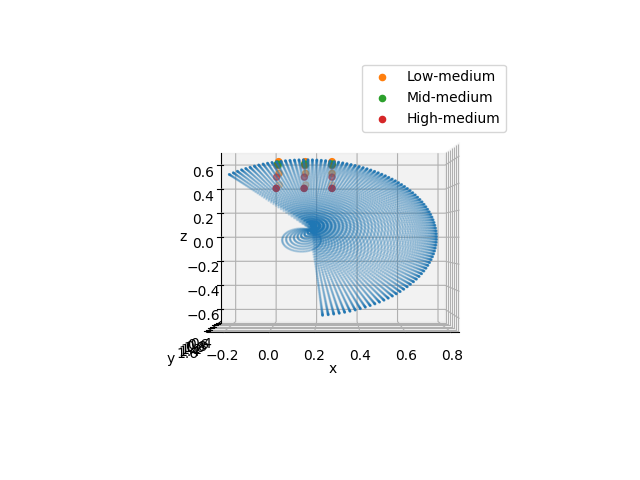

In [177]:
fig_distance = plt.figure()
ax_distance = fig_distance.add_subplot(111, projection='3d')

ax_distance.clear()

ax_distance.view_init(elev=0, azim=-90)
#ax_distance.view_init(elev=-180, azim=-135)
ax_distance.set_xlabel('x')
ax_distance.set_ylabel('y')
ax_distance.set_zlabel('z')

distance_test = pd.read_csv(table_filename, index_col=0)

#transfer reach envelope from MuJoCo to global Unity coordinates
distance_test_unity = distance_test.copy()
distance_test_unity.loc[:, "end-effector_xpos_x":"end-effector_xpos_z"] = np.array(distance_test_unity.apply(lambda x: np.array(list(test_env.task._transform_to_unity(x.loc["end-effector_xpos_x":"end-effector_xpos_z"].values, test_env._data.body("controller-right").xquat, apply_offset=True)[0].values())), axis=1).tolist())
ax_distance.invert_yaxis()

ax_distance.scatter(distance_test_unity["end-effector_xpos_x"], distance_test_unity["end-effector_xpos_y"], distance_test_unity["end-effector_xpos_z"], s=0.8, alpha=0.2)

## plot targets from VR Application in global Unity coordinates
for _task_condition in _target_info["task_condition"].unique():
    _target_info_selected = _target_info[_target_info["task_condition"] == _task_condition]
    ax_distance.scatter(_target_info_selected["global_x"], _target_info_selected["global_y"], _target_info_selected["global_z"], label=_task_condition.lstrip('0123456789-').capitalize())
ax_distance.legend()
fig_distance.savefig(figure_filename)

# ## target region (from SciRep RL paper)

# gphi = np.random.uniform(low=-1.57079633, high=0.698132, size=100000)
# #gphi = np.random.uniform(low=-1.57079633, high=-0.0872665, size=100000)
# gtheta = np.random.uniform(low=0, high=3.14159265, size=100000)
# gr = np.random.uniform(low=0.2, high=0.735, size=100000)  #high=0.735
# #ax_distance.scatter(gr*np.cos(gphi)*np.sin(gtheta), gr*np.sin(gphi)*np.sin(gtheta), gr*np.cos(gtheta), s=0.8)
# ax_distance.scatter(gr*np.cos(gphi)*np.sin(gtheta), gr*np.cos(gtheta), -gr*np.sin(gphi)*np.sin(gtheta), s=0.1, alpha=0.1)

# ## "random_v2":

# thorax_offset = np.array([0.02153019919, 0.00858509793, -0.20849523568])  #for unscaled model: np.array([0.017555, 0.007, -0.17])

# general_thorax_area = np.array([[-0.11157193, -0.32303762, -0.37799819], [0.12484449, 0.05684561, -0.03899228]])
# general_thorax_threshold = np.array([[-0.1, -2, -0.1], [0.1, 0.3, 0.1]])
# general_target_area = np.array([[0, -1, general_thorax_area[:, 2].mean()], [1, 1, 1]])

# nsamples_randomv2 = 10000
# new_target = np.zeros((nsamples_randomv2,3))
# for i in range(nsamples_randomv2):
#     draw_new_target = True
#     while draw_new_target:
#         new_target[i] = np.random.uniform(low=general_target_area[0], high=general_target_area[1], size=3)
#         if (np.linalg.norm(new_target[i]) <= 0.735 + 0.05) & ((new_target[i] < (general_thorax_area[0] + general_thorax_threshold[0])) |
#                 (new_target[i] > (general_thorax_area[1] + general_thorax_threshold[1]))).any():
#             draw_new_target = False
            
# ax_distance.scatter(new_target[:, 0], new_target[:, 1], new_target[:, 2], s=0.1, alpha=0.5)

In [ ]:
# import mujoco

# [mujoco.mju_muscleGain(env._data.actuator_length[i], env._data.actuator_velocity[i], env._model.actuator_lengthrange[i], env._model.actuator_acc0[i], env._model.actuator_gainprm[i, :9])*env._data.act[i] + mujoco.mju_muscleBias(env._data.actuator_length[i], env._model.actuator_lengthrange[i], env._model.actuator_acc0[i], env._model.actuator_biasprm[i, :9]) for i in range(env._model.nu)]

In [ ]:
#env.bm_model._effort_model._MA

### Store policy params

In [13]:
simulator_dir = "/home/florian/uitb-sim2vr/user-in-the-box-private/simulators/unity_random_3ccr_1e1_v110l"
env = uitb.Simulator.get(simulator_dir, run_parameters={"action_sample_freq": 20, "evaluate": True}, use_cloned=True)
_checkpoint_dir = f"{simulator_dir}/checkpoints"  #checkpoints_20230508_175546
# _policy_path = os.path.join(_checkpoint_dir, "model_100000000_steps")
_policy_path = os.path.join(_checkpoint_dir, natural_sort(os.listdir(_checkpoint_dir))[-1])
_policy = PPO.load(_policy_path)  #use latest policy
print(f"Policy: {_policy_path}")
_policy

Attempting to connect to Unity app on port 35161
[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-

In [14]:
dir_to_check = "/home/florian/uitb-sim2vr/user-in-the-box-private/simulators/"
print(dir_to_check + " " + str(os.path.exists(dir_to_check)))
print(dir_to_check + " READ " + str(os.access(dir_to_check, os.R_OK)))
print(dir_to_check + " WRITE " + str(os.access(dir_to_check, os.W_OK)))   

/home/florian/uitb-sim2vr/user-in-the-box-private/simulators/ True
/home/florian/uitb-sim2vr/user-in-the-box-private/simulators/ READ True
/home/florian/uitb-sim2vr/user-in-the-box-private/simulators/ WRITE True


In [15]:
_policy_filepath = f'/home/florian/uitb-sim2vr/user-in-the-box-private/uitb/rl/sb3/policies/{simulator_dir.split("/")[-1]}'
os.popen(f"mkdir -p {_policy_filepath}").read()
_policy_filename = f"parameters-{_policy_path.split('000000_steps')[0].split('_')[-1]}mil.npy"
_new_policy_path = os.path.join(_policy_filepath, _policy_filename)
print(f"New policy filename: {_new_policy_path}")

New policy filename: /home/florian/uitb-sim2vr/user-in-the-box-private/uitb/rl/sb3/policies/unity_random_3ccr_1e1_v110l/parameters-15mil.npy


In [16]:
np.save(_new_policy_path, _policy.policy.parameters_to_vector())

### Evaluations

In [13]:
## UPDATE DEBUGGING SIMULATOR
simulator_dir = uitb.Simulator.build("/home/florian/uitb-sim2vr/user-in-the-box-private/uitb/configs/mobl_arms_unity_whacamole_DEBUG.yaml")
simulator_dir = uitb.Simulator.build("/home/florian/uitb-sim2vr/user-in-the-box-private/uitb/configs/mobl_arms_unity_beatsvr_DEBUG.yaml")

In [19]:
#simulator_dir = uitb.Simulator.build("/home/florian/uitb-sim2vr/user-in-the-box-private/uitb/configs/mobl_arms_unity_low_easy_TEST.yaml")
#simulator_dir = uitb.Simulator.build("/home/florian/uitb-sim2vr/user-in-the-box-private/uitb/configs/mobl_arms_unity_high_easy_3CCr_0_v111.yaml")
# simulator_dir = uitb.Simulator.build("/home/florian/uitb-sim2vr/user-in-the-box-private/uitb/configs/mobl_arms_unity_beatsvr_1e3.yaml")

# simulator_dir = "/home/florian/uitb-sim2vr/user-in-the-box-private/simulators/unity_random_3ccr_1e1_v115"
simulator_dir = "/home/florian/uitb-sim2vr/user-in-the-box-private/simulators/unity_beatsvr_1e3"



In [53]:
# if not "env" in locals():
#     env = uitb.Simulator.get("/home/florian/uitb-sim2vr/user-in-the-box-private/trained/unity_hard_pretrained", run_parameters={"action_sample_freq": 20, "evaluate": True}, render_mode="rgb_array_list", render_show_depths=False, use_cloned=True)
# env = uitb.Simulator.get("/home/florian/uitb-sim2vr/user-in-the-box-private/trained/unity_hard_pretrained", run_parameters={"action_sample_freq": 20, "evaluate": True}, render_mode="rgb_array_list", render_show_depths=False, use_cloned=True)
# env = uitb.Simulator.get("/home/florian/uitb-sim2vr/user-in-the-box-private/trained/unity_low_pretrained", run_parameters={"action_sample_freq": 20, "evaluate": True}, use_cloned=True)
# simulator_dir = "/home/florian/uitb-sim2vr/user-in-the-box-private/trained/unity_easy"
# simulator_dir = "/home/florian/uitb-sim2vr/user-in-the-box-private/simulators/unity_difficulty_easy_cumulativefatigue_v2"
# simulator_dir = "/home/florian/uitb-sim2vr/user-in-the-box-private/simulators/test_unity_difficulty_easy_3ccr"
# simulator_dir = "/home/florian/uitb-sim2vr/user-in-the-box-private/simulators/unity_high_difficulty_easy_3ccr_0_10s"
# simulator_dir = "/home/florian/uitb-sim2vr/user-in-the-box-private/simulators/unity_difficulty_easy"

# simulator_dir = "/home/florian/uitb-sim2vr/user-in-the-box-private/simulators/unity_beatsvr_test"
# simulator_dir = "/home/florian/uitb-sim2vr/user-in-the-box-private/simulators/unity_low_difficulty_easy_test"

env = uitb.Simulator.get(simulator_dir, run_parameters={"action_sample_freq": 20,"evaluate": True}, render_mode="rgb_array_list", use_cloned=False)

# ## TEST with different effort model:
from uitb.bm_models.effort_models import CumulativeFatigue3CCr, ConsumedEndurance
# env.bm_model._effort_model = CumulativeFatigue3CCr(env.bm_model, dt=env._run_parameters["dt"])  #env.bm_model.get_effort_model({"cls": "CumulativeFatigue3CCr"}, dt=env._run_parameters["dt"])
log_variables = {
                # "3CCr_MA": ("bm_model", "_effort_model", "_MA"),   #TODO: store in info returned by simulator.step()
                # "3CCr_MR": ("bm_model", "_effort_model", "_MR"),
                # "3CCr_MF": ("bm_model", "_effort_model", "_MF"),
                # "effort_cost": ("bm_model", "_effort_model", "_effort_cost")
                }
# env.bm_model._effort_model = ConsumedEndurance(env.bm_model, dt=env._run_parameters["dt"])  #env.bm_model.get_effort_model({"cls": "ConsumedEndurance"}, dt=env._run_parameters["dt"])
# log_variables = {"endurance": ("bm_model", "_effort_model", "_endurance"),
#                 "consumed_endurance": ("bm_model", "_effort_model", "_consumed_endurance"),
#                 "act": ("_data", "act"),
#                 "effort_cost": ("bm_model", "_effort_model", "_effort_cost")}

USE_POLICY = True

# Number of steps you run the agent for 
num_steps = 5000

#############################################################


# Reset with some seed for debugging purposes
# obs = env.reset()
obs, info = env.reset()

# Create instance for variables that should be additionally logged
eval_logs = EvaluationLogs(env, log_variables)

# Create empty list which all frames of the forward simulation will be appended to
frame_collection = []

# Create list which all rewards of the forward simulation will be appended to
reward_collection = [np.nan]  #no reward available at initial state

# obs_collection = [obs]
obs_collection = defaultdict(list)
for k, v in obs.items():
    obs_collection[k].append(v)

action_collection = []
info_collection = defaultdict(list)

if USE_POLICY:
    _checkpoint_dir = f"{simulator_dir}/checkpoints"  #checkpoints_20230508_175546
    # _policy_path = os.path.join(_checkpoint_dir, "model_100000000_steps")
    _policy_path = os.path.join(_checkpoint_dir, natural_sort(os.listdir(_checkpoint_dir))[-1])  #use latest policy
    print(f"Load PPO policy {_policy_path}.")

    _policy = PPO.load(_policy_path)
else:
    _policy = None

for step in range(num_steps):
    if _policy is not None:
        # get actions from policy
        action, _internal_policy_state = _policy.predict(obs, deterministic=True)
    else:
        # choose random action from action space
        action = env.action_space.sample()    
    
    # apply the action
    # obs, reward, done, info = env.step(action)
    obs, reward, terminated, truncated, info = env.step(action)
    
    # store received reward
    reward_collection.append(reward)
    
    for k, v in obs.items():
        obs_collection[k].append(v)
    action_collection.append(action)
    for k, v in info.items():
        info_collection[k].append(v)
    
    # log additional variables
    eval_logs.log()
    
    # If the epsiode is up, then stop
    # if done:
    if terminated or truncated:
        frame_collection.extend(env.render()) #with render_mode="rgb_array_list", env.render() returns a list of all frames since last call of reset()
        break

# Also store remaining frames of unfinished last episode
frame_collection.extend(env.render())

# Close the env
env.close()

# Show all simulated frames
# display_video(frame_collection, framerate=env.fps)
#display_video_with_rewards(frame_collection, reward_collection, framerate=env.fps)

Attempting to connect to Unity app on port 54489
[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-

In [48]:
sum(reward_collection[1:])

1991.9222242105125

In [49]:
np.sum(np.diff(info_collection["Points"]))

200

In [45]:
display_video(frame_collection, framerate=env.fps)

In [19]:
#reward_collection[1:][np.argmax(reward_collection[1:])]
sum(reward_collection[1:])

1406.7753888200969

In [19]:
sum(eval_logs.get_logs("effort_cost").values())

5.3917467476000605

In [38]:
# # if not "env" in locals():
# #     env = uitb.Simulator.get("/home/florian/uitb-sim2vr/user-in-the-box-private/trained/unity_hard_pretrained", run_parameters={"action_sample_freq": 20, "evaluate": True}, render_mode="rgb_array_list", render_show_depths=False, use_cloned=True)
# # env = uitb.Simulator.get("/home/florian/uitb-sim2vr/user-in-the-box-private/trained/unity_hard_pretrained", run_parameters={"action_sample_freq": 20, "evaluate": True}, render_mode="rgb_array_list", render_show_depths=False, use_cloned=True)
# # env = uitb.Simulator.get("/home/florian/uitb-sim2vr/user-in-the-box-private/trained/unity_low_pretrained", run_parameters={"action_sample_freq": 20, "evaluate": True}, use_cloned=True)
# # simulator_dir = "/home/florian/uitb-sim2vr/user-in-the-box-private/trained/unity_easy"
# # simulator_dir = "/home/florian/uitb-sim2vr/user-in-the-box-private/simulators/unity_difficulty_easy_cumulativefatigue_v2"
# # simulator_dir = "/home/florian/uitb-sim2vr/user-in-the-box-private/simulators/test_unity_difficulty_easy_3ccr"
# # simulator_dir = "/home/florian/uitb-sim2vr/user-in-the-box-private/simulators/unity_high_difficulty_easy_3ccr"
# simulator_dir = "/home/florian/uitb-sim2vr/user-in-the-box-private/simulators/unity_difficulty_easy"

# env = uitb.Simulator.get(simulator_dir, run_parameters={"action_sample_freq": 20, "evaluate": True}, use_cloned=False)

# # ## TEST with different effort model:
# # from uitb.bm_models.effort_models import CumulativeFatigue3CCr, ConsumedEndurance
# # env.bm_model._effort_model = CumulativeFatigue3CCr(env.bm_model, dt=env._run_parameters["dt"])  #env.bm_model.get_effort_model({"cls": "CumulativeFatigue3CCr"}, dt=env._run_parameters["dt"])
# log_variables = {
#                 # "3CCr_MA": ("bm_model", "_effort_model", "_MA"), 
#                 # "3CCr_MR": ("bm_model", "_effort_model", "_MR"),
#                 # "3CCr_MF": ("bm_model", "_effort_model", "_MF"),
#                 # "effort_cost": ("bm_model", "_effort_model", "_effort_cost")
#                 }

# USE_POLICY = False

# # Number of steps you run the agent for 
# num_steps = 50#00

# #############################################################


# # Reset with some seed for debugging purposes
# # obs = env.reset()
# obs, info = env.reset()

# # Create instance for variables that should be additionally logged
# eval_logs = EvaluationLogs(env, log_variables)

# # Create empty list which all frames of the forward simulation will be appended to
# frame_collection = []

# # Create list which all rewards of the forward simulation will be appended to
# reward_collection = [np.nan]  #no reward available at initial state

# obs_collection = [obs]
# info_collection = []

# if USE_POLICY:
#     _checkpoint_dir = f"{simulator_dir}/checkpoints"  #checkpoints_20230508_175546
#     # _policy = PPO.load(os.path.join(_checkpoint_dir, "model_100000000_steps"))
#     _policy = PPO.load(os.path.join(_checkpoint_dir, natural_sort(os.listdir(_checkpoint_dir))[-1]))  #use latest policy
# else:
#     _policy = None

# for step in range(num_steps):
#     if _policy is not None:
#         # get actions from policy
#         action, _internal_policy_state = _policy.predict(obs, deterministic=True)
#     else:
#         # choose random action from action space
#         action = env.action_space.sample()    
    
#     # apply the action
#     # obs, reward, done, info = env.step(action)
#     obs, reward, terminated, truncated, info = env.step(action)
    
#     # store received reward
#     reward_collection.append(reward)
    
#     obs_collection.append(obs)
#     info_collection.append(info)
    
#     # log additional variables
#     eval_logs.log()
    
#     # If the epsiode is up, then stop
#     # if done:
#     if terminated or truncated:
#         # frame_collection.extend(env.render()) #with render_mode="rgb_array_list", env.render() returns a list of all frames since last call of reset()
#         break

# # Close the env
# env.close()

# # Also store remaining frames of unfinished last episode
# # frame_collection.extend(env.render())

# # Show all simulated frames
# # display_video(frame_collection, framerate=env.fps)
# #display_video_with_rewards(frame_collection, reward_collection, framerate=env.fps)

FileNotFoundError: [Errno 2] No such file or directory: '/home/florian/uitb-sim2vr/user-in-the-box-private/uitb/tasks/unity/build/build.x86_64'

In [ ]:
eval_logs.get_logs("effort_cost")

In [ ]:
lifting_muscles = ["DELT1", "DELT2", "DELT3", "SUPSP", "INFSP", "SUBSC", "TMIN", "BIClong", "BICshort", "TRIlong", "TRIlat", "TRImed"]  #muscles of the mobl_arms_wrist that act on the shoulder
lifting_indices = [env._model.actuator(_i).id for _i in lifting_muscles]

_logdata = eval_logs.get_logs("3CCr_MF", indices=lifting_indices)

plt.plot(_logdata.keys(), _logdata.values(), label=lifting_muscles)
plt.legend()

In [ ]:
lifting_muscles = ["DELT1", "DELT2", "DELT3", "SUPSP", "INFSP", "SUBSC", "TMIN", "BIClong", "BICshort", "TRIlong", "TRIlat", "TRImed"]  #muscles of the mobl_arms_wrist that act on the shoulder
lifting_indices = [env._model.actuator(_i).id for _i in lifting_muscles]

_logdata = eval_logs.get_logs("3CCr_MA", indices=lifting_indices)

plt.plot(_logdata.keys(), _logdata.values(), label=lifting_muscles)
plt.legend()

In [ ]:
#display_video([(np.concatenate((np.moveaxis(i["vision"], 0, 2), 0*np.ones((80, 120, 1))), axis=-1)[..., [0, 2, 1]]/2 + 0.5) for i in obs_collection], framerate=100)
display_video([i["unity_image"] for i in info_collection], framerate=100)


## Run Evaluations

In [12]:
## EVALUATE LIST OF SIMULATION DIRS

import uitb
os.chdir(uitb.__path__[0])
os.chdir("..")

SIMULATION_DIRS = [
    # "simulators/unity_low_difficulty_easy_3ccr_1e3",  #low-easy
    # "simulators/unity_difficulty_easy_3ccr_1e3",  #mid-easy
    # "simulators/unity_high_difficulty_easy_3ccr_1e3",  #high-easy
    # "simulators/unity_low_difficulty_easy_ce",  #low-easy
    # "simulators/unity_difficulty_easy_ce",  #mid-easy
    # "simulators/unity_high_difficulty_easy_ce",  #high-easy
    # "trained/unity_easy/",
    # "trained/unity_medium_pretrained/",
    # "trained/unity_hard_pretrained/",
    # "trained/unity_low_pretrained/",
    # "trained/unity_medium_pretrained/",  #mid-medium
    # "trained/unity_high_pretrained/",
    # "simulators/unity_high_difficulty_easy_3ccr_1e2_v110",  #high-easy
    # "simulators/unity_difficulty_easy_3ccr_1e2_v110",  #mid-easy
    # "simulators/unity_low_difficulty_easy_3ccr_1e2_v110",  #low-easy
    # "simulators/unity_random_easy_3ccr_1e2_v110",  #->82
    # "simulators/unity_random_3ccr_1e2_v110"  #->83
    # "simulators/unity_random_3ccr_1e2_v110l"  #->83l 
    # "simulators/unity_random_3ccr_1e2_v110lc"  #->83lc
    # "simulators/unity_random_3ccr_1e2_v112"  #->83_112
    # "simulators/unity_random_easy_medium_3ccr_1e2_v110"  #->84
    # "simulators/unity_random_3ccr_1e1_v110"  #->085
    # "simulators/unity_random_3ccr_1e1_v110l"  #->085l
    # "simulators/unity_random_3ccr_1e1_v110lc"  #->085lc
    # "simulators/unity_largenet_random_3ccr_1e1_v110"  #->085LN
    # "simulators/unity_random_easy_medium_3ccr_1e1_v110"  #->086
    # "simulators/unity_random_3ccr_1e1_v113"  #->087
    # "simulators/unity_largenet_random_adaptive_3ccr_1e1_v114"  #->087LN
    # "simulators/unity_random_neural_1e3_v110"  #->088
    # "simulators/unity_random_3ccr_0_v110"  #->089
    # "simulators/unity_random_sparse_3ccr_1e1_v114"  #->090

    # "simulators/unity_random_3ccr_1e1_v115"  #->85
    # "simulators/unity_random_unc_3ccr_1e1_v115"  #->85unc
    "simulators/unity_random_adaptive_3ccr_1e1_v115_run2"  #->87
    # "simulators/unity_random_neural_1e3_v115"  #->88
    # "simulators/unity_random_3ccr_0_v115"  #->89
    # "simulators/unity_random_sparse_3ccr_1e1_v115"  #->90

    # "simulators/unity_beatsvr_1e3"  #->beats01
    ]

# APP_CONDITIONS = ["low-easy", "easy", "high-easy"]
# APP_CONDITIONS = ["low-medium", "medium", "high-medium"]
# APP_CONDITIONS = ["easy", "medium", "hard"]
# APP_CONDITIONS = ["easy", "high-easy"]
# APP_CONDITIONS = ["low-easy", "easy", "high-easy", "low-medium", "medium", "high-medium"]
APP_CONDITIONS = ["easy", "medium", "hard", "low-medium", "medium", "high-medium"]
# APP_CONDITIONS = ["easy-unconstrained", "medium-unconstrained", "hard-unconstrained", "low-medium-unconstrained", "medium-unconstrained", "high-medium-unconstrained"]

_RECORD = True  #True

#_SIMULATION_USER_ID = 204  #fake simulation user ID used for testing
for _SIMULATION_USER_ID in ["87_r2"]:  #range(8501, 8513):
    for _TASK_CONDITION in SIMULATION_DIRS:
        print(f"\n\nTASK CONDITION: {_TASK_CONDITION}\n")
        # os.environ["_TASK_CONDITION"] = _TASK_CONDITION
        for _app_condition in APP_CONDITIONS:
            print(f"APP CONDITION: {_app_condition}\n")
            # os.environ["_app_condition"] = _app_condition

            # %run uitb/test/evaluator_OLD.py $_TASK_CONDITION --num_episodes 1 --logging
            # %run uitb/test/evaluator.py $_TASK_CONDITION --num_episodes 1 --record --logging
            os.system(f"python uitb/test/evaluator.py {_TASK_CONDITION} --num_episodes 1 {'--record' if _RECORD else ''} --logging --uncloned --app_condition {_app_condition}")  #--checkpoint model_100000000_steps.zip")
            # os.system(f"python uitb/test/evaluator.py {_TASK_CONDITION} --num_episodes 1 {'--record' if _RECORD else ''} --logging --app_condition {_app_condition}")

            _copy_to_dataset(TASK_CONDITION=_TASK_CONDITION, SIMULATION_USER_ID=_SIMULATION_USER_ID, record=_RECORD, logging=True)



TASK CONDITION: simulators/unity_random_adaptive_3ccr_1e1_v115_run2

APP CONDITION: easy

Attempting to connect to Unity app on port 44779
[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memoryset

In [ ]:
# import uitb
# os.chdir(uitb.__path__[0])
# os.chdir("..")

# _TASK_CONDITION = "trained/unity_high_pretrained"  #OPTIONS: "trained/unity_easy", "trained/unity_medium_pretrained", "trained/unity_hard_pretrained", "trained/unity_low_pretrained", "trained/unity_high_pretrained"
# _TASK_CONDITION = "simulators/test_unity_difficulty_easy_3ccr"

# _TASK_CONDITION = "simulators/unity_high_difficulty_easy_3ccr_1e5"

# os.environ["_TASK_CONDITION"] = _TASK_CONDITION
# %run uitb/test/evaluator.py $_TASK_CONDITION --num_episodes 1 --record --logging
# # %run uitb/test/evaluator.py $_TASK_CONDITION --num_episodes 10 --logging

Copy evaluation logs (including pickle files) to dataset directory

In [ ]:
_SIMULATION_USER_ID = 91  #fake simulation user ID used for testing
_copy_to_dataset(TASK_CONDITION=_TASK_CONDITION, SIMULATION_USER_ID=_SIMULATION_USER_ID)

In [ ]:
_rng = np.random.default_rng()
strength = _rng.uniform(0, 1, size=32)

In [ ]:
# if strength > 0.15:
#     endurance = (1236.5/((strength*100 - 15)**0.618)) - 72.5
# else:
#     endurance = np.inf
endurance = np.inf * np.ones_like(strength)
endurance[strength > 0.15] = (1236.5/((strength[strength > 0.15]*100 - 15)**0.618)) - 72.5
0.02/np.min(endurance)*100, 0.02/endurance*100

np.mean(endurance[endurance<np.inf]), (1236.5/((np.mean(strength)*100 - 15)**0.618)) - 72.5

**NOTES on simulation user IDs:**
- 99: testing
- 91: Aleksi's trained models evaluated with 3CCr costs
- 92: Aleksi's trained models evaluated with CE costs
- 901: trained with 3CCr costs (cost weight: 1e-3)
- 902: trained with CE costs
- 8501-8512: trained with 3ccr costs (cost weight: 1e-1), whac-a-mole v1.1.0, with special intermediate training on left targets (100M regul. + 15M left-only + 50M regul. training steps)

**Evaluate fatigue/effort metrics for different conditions.**

In [ ]:
lifting_muscles = ["DELT1", "DELT2", "DELT3", "SUPSP", "INFSP", "SUBSC", "TMIN", "BIClong", "BICshort", "TRIlong", "TRIlat", "TRImed"]  #muscles of the mobl_arms_wrist that act on the shoulder
lifting_indices = [0, 1, 2, 3, 4, 5, 6, 20, 21, 15, 16, 17]  #[env._model.actuator(_i).id for _i in lifting_muscles]

In [ ]:
_test = np.load("/home/florian/uitb-sim2vr/user-in-the-box-private/datasets/vr-uitb-experiment/91/09-22-59-low/state_log.pickle", allow_pickle=True)
np.mean([np.mean(i["effort_cost"][1:]) for i in _test.values()])
np.mean([np.mean(list(map(np.mean, i["3CCr_MF"]))) for i in _test.values()])
np.mean([np.mean(list(map(lambda x: np.mean(x[lifting_indices]), i["3CCr_MF"]))) for i in _test.values()])

In [ ]:
_test = np.load("/home/florian/uitb-sim2vr/user-in-the-box-private/datasets/vr-uitb-experiment/91/09-25-50-mid/state_log.pickle", allow_pickle=True)
_test["episode_00"]["effort_cost"]
np.mean([np.mean(i["effort_cost"][1:]) for i in _test.values()])
np.mean([np.mean(list(map(np.mean, i["3CCr_MF"]))) for i in _test.values()])
np.mean([np.mean(list(map(lambda x: np.mean(x[lifting_indices]), i["3CCr_MF"]))) for i in _test.values()])

In [ ]:
_test = np.load("/home/florian/uitb-sim2vr/user-in-the-box-private/datasets/vr-uitb-experiment/91/09-29-58-high/state_log.pickle", allow_pickle=True)
_test["episode_00"]["effort_cost"]
np.mean([np.mean(i["effort_cost"][1:]) for i in _test.values()])
np.mean([np.mean(list(map(np.mean, i["3CCr_MF"]))) for i in _test.values()])
np.mean([np.mean(list(map(lambda x: np.mean(x[lifting_indices]), i["3CCr_MF"]))) for i in _test.values()])

## Run Training

Run from command line with X11 (e.g., using MobaXterm):
```python
export DISPLAY=:1
python uitb/train/trainer.py uitb/configs/mobl_arms_unity_test1.yaml
```

## Utils

Copy build files (i.e., a standalone Unity app for each task condition/target setup) to source dir.

In [ ]:
for _cond in ["unity_easy", "unity_medium_pretrained", "unity_hard_pretrained", "unity_low_pretrained", "unity_high_pretrained"]:
    os.popen(f"mkdir ~/uitb-sim2vr/user-in-the-box-private/uitb/tasks/unity/build/{_cond.split('_')[1]}")
    os.popen(f"cp ~/uitb-sim2vr/user-in-the-box-private/trained/{_cond}/{_cond}/tasks/unity/build/build.x86_64 ~/uitb-sim2vr/user-in-the-box-private/uitb/tasks/unity/build/{_cond.split('_')[1]}/build.x86_64")
    os.popen(f"cp ~/uitb-sim2vr/user-in-the-box-private/trained/{_cond}/{_cond}/tasks/unity/build/UnityPlayer.so ~/uitb-sim2vr/user-in-the-box-private/uitb/tasks/unity/build/{_cond.split('_')[1]}/UnityPlayer.so")
    os.popen(f"cp ~/uitb-sim2vr/user-in-the-box-private/trained/{_cond}/{_cond}/tasks/unity/build/build_Data ~/uitb-sim2vr/user-in-the-box-private/uitb/tasks/unity/build/{_cond.split('_')[1]}/ -r")